# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
USER_NAME = u"Лютов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + C w
$$

## Имплементация (5 баллов)

In [114]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=0.01, alpha=0.1, max_epoch=1000, random_state=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.tolerance = 1e-6
        self.random_state = None
    
    def fit(self, X, y=None, loss_history=False):
        '''
        Обучение модели
        '''
        l = X.shape[0]
        X = np.block([X, np.ones((l, 1))])

        y = y.astype(np.float32)
        y -= y.min()
        y /= y.max() / 2.0
        y -= 1

        np.random.seed(self.random_state)
        self.w = np.random.rand(X.shape[1]) * 2 - 1

        indeces = np.arange(l)
        BATCH_SIZE = 128
        alpha = self.alpha
        
        self.loss_history = []

        for i in tqdm(range(self.max_epoch)):
            old_w = self.w.copy()
            np.random.shuffle(indeces)

            for batch_number in range(0, l, BATCH_SIZE):
                batch = indeces[batch_number:batch_number + BATCH_SIZE]
                g = self.calc_gradient(X[batch, :], y[batch])
                self.w -= g * alpha
            
            if loss_history:
                self.loss_history.append(self.calc_loss(X, y))

            if ((self.w - old_w) ** 2).sum() <= self.tolerance:
                break
            elif i % 20 == 0:
                alpha *= 0.98

        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''

        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        X = np.block([X, np.ones((X.shape[0], 1))])

        result = 1 / (1 + np.exp(-X.dot(self.w)))
        return np.hstack([1 - result.reshape([-1, 1]), result.reshape([-1, 1])])

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        g = -y[:, np.newaxis] * X * expit(-y * X.dot(self.w))[:, np.newaxis]
        return g.mean(axis=0) + self.C * self.w

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float
        """
        return (np.logaddexp(0, -y * X.dot(self.w)).mean() +
                self.C / 2.0 * np.sum(self.w ** 2))

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [85]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

 42%|████▏     | 419/1000 [00:00<00:00, 4188.50it/s]


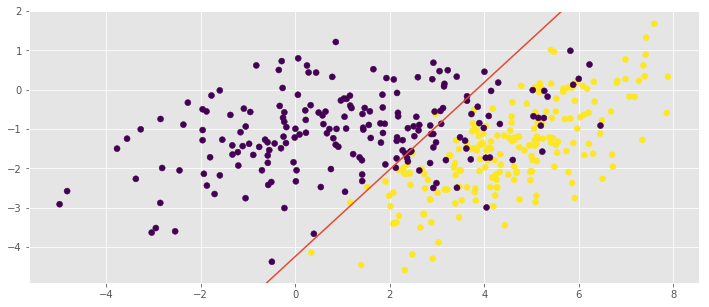

array([ 0.80940347, -0.7319794 , -3.10122362])

In [115]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

model = MySGDClassifier()
model.fit(X, y)

plt.scatter(X[:,0], X[:,1], c=y)
newline([-model.w[2] / model.w[0], 0], [0, -model.w[2] / model.w[1]])
plt.show()

model.w

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [105]:
from sklearn.datasets import make_classification

In [106]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

 36%|███▌      | 356/1000 [00:00<00:00, 3552.01it/s]


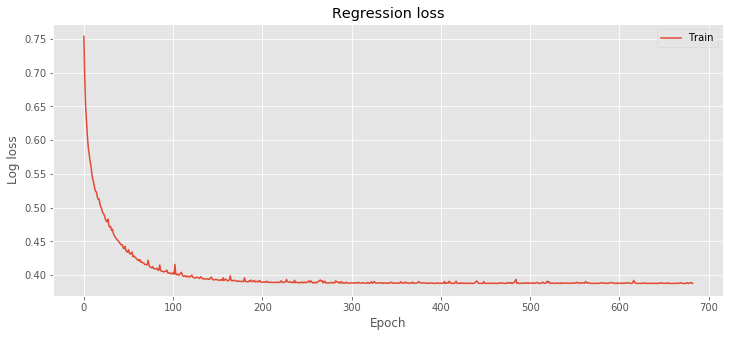

In [124]:
model = MySGDClassifier()
model.fit(X, y, loss_history=True)

plt.plot(model.loss_history, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Regression loss")
plt.show()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [126]:
## Your Code Here
y.min()

0.0

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [127]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [128]:
df_data.shape

(2000000, 45)

In [129]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [131]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50479949999999996

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [140]:
(df_data["player_hand_nOfCards"] + df_data["player_played_nOfCards"]).head()

gamestate_id
4687346.0    10
3270826.0    12
3189487.0     5
4098946.0    10
2661127.0     5
dtype: int64

In [141]:
df_data["opponent_played_nOfCards"].head()

gamestate_id
4687346.0    1
3270826.0    1
3189487.0    2
4098946.0    0
2661127.0    4
Name: opponent_played_nOfCards, dtype: int64

In [143]:
o_columns = [col for col in df_data.columns if col.endswith("_id")]
o_data = pd.get_dummies(df_data, columns=o_columns)

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [144]:
y = o_data["decision"].values
X = o_data.drop("decision", axis=1).values

In [145]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
estimators = [('standart', StandardScaler()), ('clf', MySGDClassifier())]
pipe = Pipeline(estimators)

In [146]:
pipe.fit(X, y)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)

100%|██████████| 1000/1000 [41:37<00:00,  2.78s/it]


Pipeline(memory=None,
     steps=[('standart', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=0.01, alpha=0.1, max_epoch=1000, random_state=None))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [148]:
## Youd Code Here
df_list = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_test_data = pd.concat(df_list)

In [153]:
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')
o_columns = [col for col in df_test_data.columns if col.endswith("_id")]
o_data = pd.get_dummies(df_test_data, columns=o_columns)

X_test = o_data.drop("decision", axis=1).values

In [169]:
y_score = pipe.predict_proba(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [165]:
y_test = pd.read_csv("./deprecated_testLabels.txt", names=["decision"])["decision"].values

array([1, 1, 1, ..., 0, 1, 0])

In [172]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_score[:, 1])

0.79559680915574071